In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-02-20 23:17:06.790620: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 23:17:06.790751: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 23:17:06.958314: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
# Load a dataset into a Pandas Dataframe
dataset_df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (8693, 14)


In [3]:
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.15.0
TensorFlow Decision Forests v1.8.1


<Axes: xlabel='Transported'>

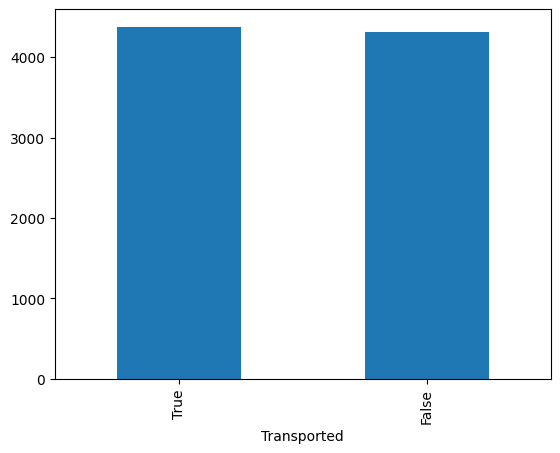

In [4]:
plot_df = dataset_df.Transported.value_counts()
plot_df.plot(kind="bar")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

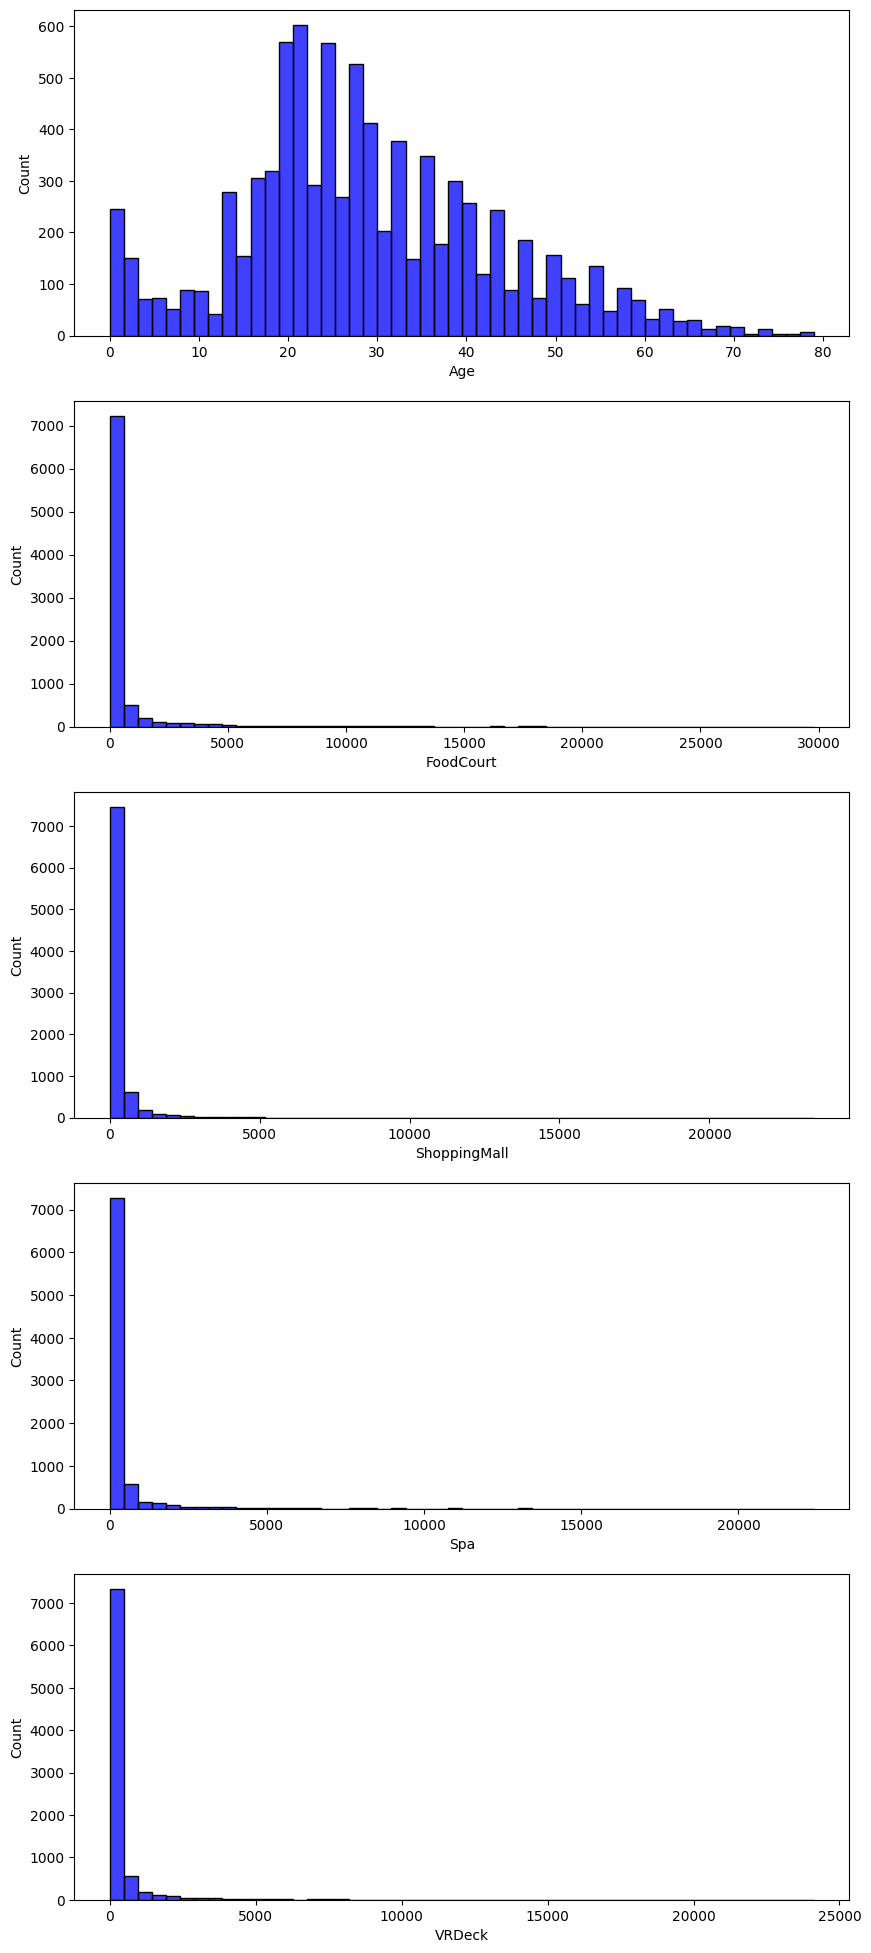

In [5]:
fig, ax = plt.subplots(5,1,  figsize=(10, 10))
plt.subplots_adjust(top = 2)

sns.histplot(dataset_df['Age'], color='b', bins=50, ax=ax[0]);
sns.histplot(dataset_df['FoodCourt'], color='b', bins=50, ax=ax[1]);
sns.histplot(dataset_df['ShoppingMall'], color='b', bins=50, ax=ax[2]);
sns.histplot(dataset_df['Spa'], color='b', bins=50, ax=ax[3]);
sns.histplot(dataset_df['VRDeck'], color='b', bins=50, ax=ax[4]);

In [6]:
dataset_df = dataset_df.drop(['PassengerId', 'Name'], axis=1)
dataset_df.head(5)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


In [7]:
dataset_df.isnull().sum().sort_values(ascending=False)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
Transported       0
dtype: int64

In [8]:
dataset_df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = dataset_df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(value=0)
dataset_df.isnull().sum().sort_values(ascending=False)

HomePlanet      201
Cabin           199
Destination     182
RoomService     181
Age             179
CryoSleep         0
VIP               0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
dtype: int64

In [9]:
label = "Transported"
dataset_df[label] = dataset_df[label].astype(int)

In [10]:
dataset_df['VIP'] = dataset_df['VIP'].astype(int)
dataset_df['CryoSleep'] = dataset_df['CryoSleep'].astype(int)

In [11]:
dataset_df[["Deck", "Cabin_num", "Side"]] = dataset_df["Cabin"].str.split("/", expand=True)

In [12]:
def split_dataset(dataset, test_ratio=0.20):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

6981 examples in training, 1712 examples in testing.


In [13]:
try:
    dataset_df = dataset_df.drop('Cabin', axis=1)
except KeyError:
    print("Field does not exist")

In [14]:
def split_dataset(dataset, test_ratio=0.20):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

6896 examples in training, 1797 examples in testing.


In [15]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label)

In [16]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [17]:
rf = tfdf.keras.RandomForestModel()
rf.compile(metrics=["accuracy"]) # Optional, you can use this to include a list of eval metrics

Use /tmp/tmpuybc8s5e as temporary training directory


In [18]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:07.339391. Found 6896 examples.
Training model...


[INFO 24-02-20 23:18:18.7033 UTC kernel.cc:1233] Loading model from path /tmp/tmpuybc8s5e/model/ with prefix bdb3818e37e84833


Model trained in 0:00:48.291355
Compiling model...


[INFO 24-02-20 23:18:19.8832 UTC decision_forest.cc:660] Model loaded with 300 root(s), 230338 node(s), and 13 input feature(s).
[INFO 24-02-20 23:18:19.8833 UTC abstract_model.cc:1344] Engine "RandomForestGeneric" built
[INFO 24-02-20 23:18:19.8833 UTC kernel.cc:1061] Use fast generic engine


Model compiled.


In [19]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

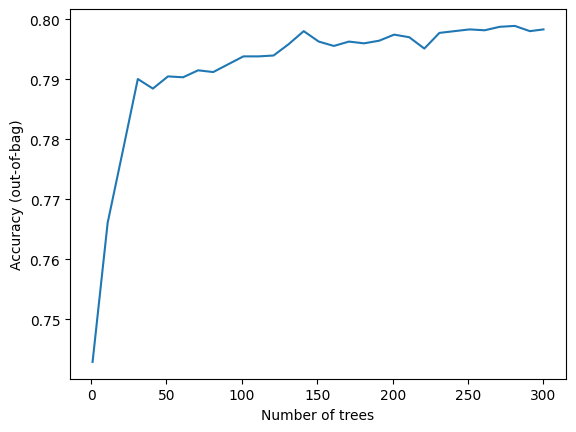

In [20]:
import matplotlib.pyplot as plt
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.show()

In [21]:
# Load the test dataset
test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
submission_id = test_df.PassengerId

# Replace NaN values with zero
test_df[['VIP', 'CryoSleep']] = test_df[['VIP', 'CryoSleep']].fillna(value=0)

# Creating New Features - Deck, Cabin_num and Side from the column Cabin and remove Cabin
test_df[["Deck", "Cabin_num", "Side"]] = test_df["Cabin"].str.split("/", expand=True)
test_df = test_df.drop('Cabin', axis=1)

# Convert boolean to 1's and 0's
test_df['VIP'] = test_df['VIP'].astype(int)
test_df['CryoSleep'] = test_df['CryoSleep'].astype(int)

# Convert pd dataframe to tf dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df)

# Get the predictions for testdata
predictions = rf.predict(test_ds)
n_predictions = (predictions > 0.5).astype(bool)
output = pd.DataFrame({'PassengerId': submission_id,
                       'Transported': n_predictions.squeeze()})

output.head()

5/5 [==============================] - 0s 68ms/step


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


In [22]:
sample_submission_df = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')
sample_submission_df['Transported'] = n_predictions
sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
sample_submission_df.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
